## Setup Packages
Recommended to use [Anaconda](https://www.anaconda.com/l) in combination with an environment. Installation commands for all required packages can be found below.

In [ ]:
# With Anaconda
!conda install ipykernel requests pandas numpy scikit-learn nltk matplotlib pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
!pip install wget 

# Without Anaconda
# !pip install wget ipykernel requests pandas numpy scikit-learn nltk matplotlib torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

## Datasets
Select and download datasets.

Available datasets:  
[0](http://help.sentiment140.com/for-students) - 1,600,000 automatically labelled tweets.  
1 -   
[2](https://ieee-dataport.org/open-access/stock-market-tweets-data#files) - 1,300 manually labelled financial tweets.  
[3](https://arxiv.org/abs/1307.5336) - 4,840 manually labelled fiancial news headlines.

In [132]:
import wget, os

# Select databases you want to use for training the model
DATASETS_SELECTED = [0, 1, 2, 3, 4]

# http://help.sentiment140.com/for-students - 10,000
# https://nlp.stanford.edu/sentiment/code.html
# https://ieee-dataport.org/open-access/stock-market-tweets-data#files - Hosted on own Nextcloud server
# https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news - Hosted on own Nextcloud server
# https://github.com/ajayshewale/Sentiment-Analysis-of-Text-Data-Tweets- - Hosted on own Nextcloud server

all_urls = ["http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip", "http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip", "https://nextcloud.lucashost.nl/s/bm8bqeKqdyFqiTe/download/tweets.zip", "https://nextcloud.lucashost.nl/s/2b4tNYKQp9jP7Bn/download/archive.zip", "https://nextcloud.lucashost.nl/s/tdC65kRGWzYzeP2/download/punkt.zip"]
urls = [all_urls[i] for i in DATASETS_SELECTED]
path = "datasets/"

if not os.path.exists(path):
  os.makedirs(path)

for url in urls:
    split_url = url.split("/")
    if not (os.path.exists(path + split_url[-1])):
      wget.download(url, out = path)

In [133]:
import zipfile

for filename in os.listdir(path):
    if filename.endswith(".zip"):
        with zipfile.ZipFile(path + filename, 'r') as zip_ref:
            zip_ref.extractall(path)

Preprocess the differrent datasets and integrate them with eachother.

In [134]:
import pandas as pd
import numpy as np
import math

for i in DATASETS_SELECTED:
    if (i == 0):
        continue
    elif (i ==1):
        continue
    elif (i ==2):
        continue
    elif (i == 3):
        df1 = pd.read_csv(path + 'all-data.csv', names=['Sentiment', 'Sentence'], encoding='ISO-8859-1')
        df1['Sentiment'] = df1['Sentiment'].astype('string')
        df1['Sentence'] = df1['Sentence'].astype('string')
        # df.head(10)
    elif (i == 4):
        df2 = pd.read_csv(path + "train.csv")
        df2 = df2.drop(columns=["Id"])
        df2 = df2.dropna()
        df2 = df2[df2["Tweet"] != "Not Available"]
        df2 = df2[df2["Category"] != "Tweet"]
        df2 = df2.rename(columns={"Category": "Sentiment", "Tweet": "Sentence"})
        df1 = df1.append(df2, ignore_index=True)
    else:
        print("Database " + str(i) + " not found")

Sentences are normalized, over- and/or undersampled, stemmed, tokenized and encoded.

In [135]:
import re

def normalize_text(sentence):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    sentence = re.sub(link_re_pattern, "", sentence)
    sentence = re.sub(mention_re_pattern, "", sentence)
    return sentence.lower()

df1["Sentence"] = df1["Sentence"].apply(normalize_text)

In [137]:
# How much you oversample compared to undersampling
FACTOR = 0.5

oversample_rate = math.floor((df1["Sentiment"].value_counts()[0] - df1["Sentiment"].value_counts()[-1]) * FACTOR)
undersample_rate = math.ceil((df1["Sentiment"].value_counts()[0] - df1["Sentiment"].value_counts()[-1]) * (1 - FACTOR))

most_df = df1[df1["Sentiment"] == df1["Sentiment"].value_counts().index[0]]
mid_df = df1[df1["Sentiment"] == df1["Sentiment"].value_counts().index[1]]
least_df = df1[df1["Sentiment"] == df1["Sentiment"].value_counts().index[2]]

drop_indices = np.random.choice(most_df.index, undersample_rate, replace=False)
undersampled = most_df.drop(drop_indices)
oversampled = least_df.append(least_df.sample(oversample_rate, replace=True))

midsample_rate = oversampled["Sentiment"].value_counts()[0] - mid_df["Sentiment"].value_counts()[0]

if (midsample_rate < 0):
    mid_drop_indices = np.random.choice(mid_df.index, -midsample_rate, replace=False)
    midsampled = mid_df.drop(mid_drop_indices)
else:
    midsampled = mid_df.append(mid_df.sample(midsample_rate, replace=True))

balanced_df = pd.concat([oversampled, midsampled, undersampled])
balanced_df["Sentiment"].value_counts()

negative    3152
positive    3152
neutral     3152
Name: Sentiment, dtype: int64

In [138]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

porter_stemmer  = PorterStemmer()

def tokenization(sentence):
    sentence = word_tokenize(sentence)
    for idx, word in enumerate(sentence):
        sentence[idx] = porter_stemmer.stem(word)
    return sentence

balanced_df["Sentence"] = balanced_df["Sentence"].apply(tokenization)

In [139]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for index, row in balanced_df.iterrows():
    for token in row["Sentence"]:
        if token not in index2word:
                index2word.append(token)

word2index = {token: idx for idx, token in enumerate(index2word)}

In [140]:
def sentiment_map(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "neutral":
        return 1
    else: #positive
        return 2

def encode_and_pad(sentence, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(sentence) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(sentence)
        encoded = [word2index[w] for w in sentence]
        return sos + encoded + eos + pad * n_pads 
    else: # sentence is longer than possible; truncating
        encoded = [word2index[w] for w in sentence]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

SEQ_LENGTH = 32

encoded = [(encode_and_pad(row["Sentence"], SEQ_LENGTH), sentiment_map(row["Sentiment"])) for index, row in balanced_df.iterrows()]

Split the dataset into a training and testing set.

In [141]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

TEST_SIZE = 0.15
BATCH_SIZE = 50

train_encoded, test_encoded = train_test_split(encoded, test_size=TEST_SIZE)

train_x = np.array([sentence for sentence, sentiment in train_encoded])
train_y = np.array([sentiment for sentence, sentiment in train_encoded])
test_x = np.array([sentence for sentence, sentiment in test_encoded])
test_y = np.array([sentiment for sentence, sentiment in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# drop_last is used to drop the final batch if does not have BATCH_SIZE elements
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## Neural Network

Create a LSTM neural network.

In [152]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Sentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 3)
    def forward(self, x, hidden):
        embs = self.embedding(x)
        out, hidden = self.lstm(embs, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        # We extract the scores for the final hidden state
        out = out[:, -1]
        return out, hidden
    def init_hidden(self):
        return (torch.zeros(self.num_layers, BATCH_SIZE, self.hidden_dim), torch.zeros(1, BATCH_SIZE, self.hidden_dim))

In [153]:
LEARNING_RATE = 0.001

model = LSTM_Sentiment(len(word2index), 64, 32, 1, 0.2)
# model = model.to(dtype=torch.double)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Train LSTM neural network.

In [154]:
import time
from sklearn.metrics import accuracy_score

NUM_EPOCHS = 20

start=time.time()
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    # Train mode
    model.train()

    for batch_idx, batch in enumerate(train_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            train_loss = criterion(out, target.long())
            train_loss.backward()
            optimizer.step()

        pred = torch.argmax(out, dim=1)
        correct = torch.sum(torch.eq(pred, target)).item()

        elapsed = time.time() - start
        
        if not batch_idx % (len(train_dl) / 4):
            print(f'epoch: {epoch}, batch: {batch_idx: <{len(str(len(train_dl)))}}/{len(train_dl)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
    
    train_losses.append(train_loss.item())

    # Evaluation mode
    model.eval()

    batch_acc = []
    for batch_idx, batch in enumerate(test_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            out, hidden = model(input, (h0, c0))
            _, preds = torch.max(out, 1)
            preds = preds.to(device).tolist()
            batch_acc.append(accuracy_score(preds, target.tolist()))

            test_loss = criterion(out, target.long())

    print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

    test_losses.append(test_loss.item())

epoch: 0, batch: 0  /160, time: 0.024s, loss: 1.113, acc: 0.260
epoch: 0, batch: 40 /160, time: 0.351s, loss: 1.094, acc: 0.440
epoch: 0, batch: 80 /160, time: 0.603s, loss: 1.103, acc: 0.320
epoch: 0, batch: 120/160, time: 0.872s, loss: 1.100, acc: 0.280
Accuracy on the test set: 0.323
epoch: 1, batch: 0  /160, time: 1.209s, loss: 1.096, acc: 0.360
epoch: 1, batch: 40 /160, time: 1.470s, loss: 1.100, acc: 0.280
epoch: 1, batch: 80 /160, time: 1.733s, loss: 1.100, acc: 0.400
epoch: 1, batch: 120/160, time: 1.998s, loss: 1.097, acc: 0.380
Accuracy on the test set: 0.325
epoch: 2, batch: 0  /160, time: 2.320s, loss: 1.101, acc: 0.160
epoch: 2, batch: 40 /160, time: 2.574s, loss: 1.096, acc: 0.380
epoch: 2, batch: 80 /160, time: 2.828s, loss: 1.094, acc: 0.440
epoch: 2, batch: 120/160, time: 3.085s, loss: 1.102, acc: 0.300
Accuracy on the test set: 0.335
epoch: 3, batch: 0  /160, time: 3.405s, loss: 1.096, acc: 0.420
epoch: 3, batch: 40 /160, time: 3.660s, loss: 1.096, acc: 0.400
epoch: 3

Evaluate the trained model.

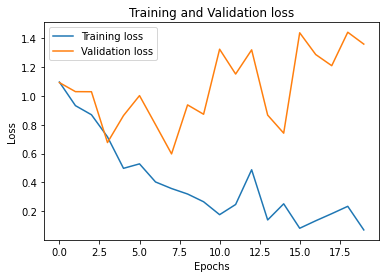

In [86]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [88]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input, target = batch[0].to(device), batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to(device).tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

print(f'Final accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

Final accuracy on the test set: 0.663


In [1]:
from auth import CLIENT_ID, SECRET_KEY, REDDIT_USERNAME, REDDIT_PASSWORD

import requests

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

data = {
    "grant_type": "password",
    "username": REDDIT_USERNAME,
    "password": REDDIT_PASSWORD
}

headers = {"User-Agent": "MyAPI/0.0.1"}

res = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers)

TOKEN = res.json()["access_token"]

headers["Authorization"] = f'bearer {TOKEN}'

requests.get("https://oauth.reddit.com/api/v1/me", headers=headers).json()

{'is_employee': False,
 'seen_layout_switch': False,
 'has_visited_new_profile': False,
 'pref_no_profanity': True,
 'has_external_account': False,
 'pref_geopopular': '',
 'seen_redesign_modal': False,
 'pref_show_trending': True,
 'subreddit': {'default_set': True,
  'user_is_contributor': False,
  'banner_img': '',
  'restrict_posting': True,
  'user_is_banned': False,
  'free_form_reports': True,
  'community_icon': None,
  'show_media': True,
  'icon_color': '',
  'user_is_muted': False,
  'display_name': 'u_Rubinjo_L',
  'header_img': None,
  'title': '',
  'coins': 0,
  'previous_names': [],
  'over_18': False,
  'icon_size': [256, 256],
  'primary_color': '',
  'icon_img': 'https://styles.redditmedia.com/t5_5ga0v8/styles/profileIcon_snoo7e1baabd-7daf-4774-a95d-92829e511322-headshot.png?width=256&amp;height=256&amp;crop=256:256,smart&amp;s=5bf6cac6695af43722caff15194db1958f1fc158',
  'description': '',
  'submit_link_label': '',
  'header_size': None,
  'restrict_commenting': Fa

In [2]:
res = requests.get("https://oauth.reddit.com/r/python/hot", headers=headers)
res.json()

{'kind': 'Listing',
 'data': {'after': 't3_rattcx',
  'dist': 27,
  'modhash': None,
  'geo_filter': None,
  'children': [{'kind': 't3',
    'data': {'approved_at_utc': None,
     'subreddit': 'Python',
     'selftext': "It's (almost) December, which means it's time for [Advent of Code](https://adventofcode.com/)! \n\n[Advent of Code](https://adventofcode.com/2021/about) is a yearly advent calendar where there's a new programming puzzle each day. They vary in difficulty and don't require a computer science background to solve. You can solve the problems using any programming language you like, so while we love python here, you can take this as an opportunity to explore other languages. If you have trouble with one of the puzzles, don't worry, another day's puzzle might be easier for you!\n\nThis year we're joining our sister community, /r/LearnPython, for a shared leaderboard. The /r/Python and /r/LearnPython leaderboard code is: `1179846-33292986`\n\nIf you want to talk about your sol